## Creation d'un reseau CNN avec tf + keras sans entrainement juste pour calculer le feature map
### 🔹 Données de départ

On crée :

* une **image** (matrice 5×5)
* un **filtre (kernel)** de taille 3×3
* on applique une **convolution** avec :

  * `stride = 1`
  * `padding = 0`








In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# ====== Image d'entrée simulée (5x5) ======
image = np.array([
    [1, 2, 3, 0, 1],
    [0, 1, 2, 3, 1],
    [1, 0, 1, 2, 2],
    [2, 1, 0, 1, 3],
    [1, 2, 1, 0, 2]
], dtype=np.float32)

# On reshape pour le format attendu par Keras: (batch, hauteur, largeur, canaux)
image = image.reshape((1, 5, 5, 1))

In [66]:
# ====== Filtre (3x3) ======
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=np.float32)

# On reshape pour (hauteur, largeur, canaux_in, canaux_out)
kernel = kernel.reshape((3, 3, 1, 1))

In [67]:
# ====== Couche Convolutionnelle (sans activation, pas d'entraînement) ======
conv_layer = tf.keras.layers.Conv2D(
    filters=1,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='valid',
    use_bias=False
)

# On force les poids du filtre (pas d'entraînement)
conv_layer.build((1, 5, 5, 1))
conv_layer.set_weights([kernel])


In [68]:
# ======  Application de la convolution ======
feature_map = conv_layer(image)
feature_map_np = feature_map[0, :, :, 0].numpy()

# ====== Résultat ======
print("Image d'entrée :\n", image[0, :, :, 0])
print("\nFiltre utilisé :\n", kernel[:, :, 0, 0])
print("\nFeature map (résultat de la convolution) :\n", feature_map_np)


Image d'entrée :
 [[1. 2. 3. 0. 1.]
 [0. 1. 2. 3. 1.]
 [1. 0. 1. 2. 2.]
 [2. 1. 0. 1. 3.]
 [1. 2. 1. 0. 2.]]

Filtre utilisé :
 [[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]

Feature map (résultat de la convolution) :
 [[-4. -2.  2.]
 [ 0. -4. -3.]
 [ 2.  0. -5.]]


## La viz avec matplotlib

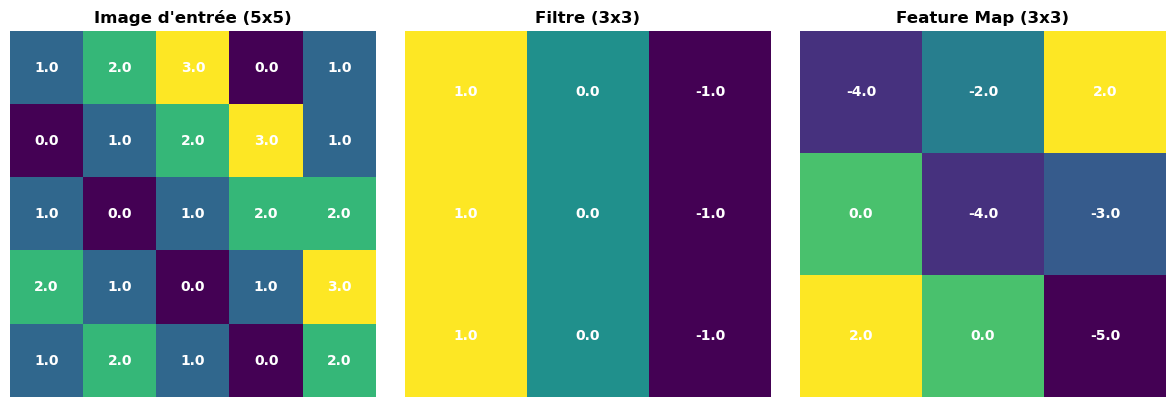

 Image d'entrée :
 [[1. 2. 3. 0. 1.]
 [0. 1. 2. 3. 1.]
 [1. 0. 1. 2. 2.]
 [2. 1. 0. 1. 3.]
 [1. 2. 1. 0. 2.]]

 Filtre utilisé :
 [[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]

 Feature Map (résultat de la convolution) :
 [[-4. -2.  2.]
 [ 0. -4. -3.]
 [ 2.  0. -5.]]


In [69]:
def show_matrix(ax, mat, title, cmap='viridis'):
    im = ax.imshow(mat, cmap=cmap)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Affichage des valeurs à l'intérieur
    rows, cols = mat.shape
    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, f"{mat[i, j]:.1f}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    return im

# ======  Affichage ======
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

show_matrix(axes[0], image[0, :, :, 0], "Image d'entrée (5x5)")
show_matrix(axes[1], kernel[:, :, 0, 0], "Filtre (3x3)")
show_matrix(axes[2], feature_map_np, "Feature Map (3x3)")

plt.tight_layout()
plt.show()

# ======  Affichage texte ======
print(" Image d'entrée :\n", image[0, :, :, 0])
print("\n Filtre utilisé :\n", kernel[:, :, 0, 0])
print("\n Feature Map (résultat de la convolution) :\n", feature_map_np)

In [70]:
# Ajoutons le max pooling
pool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')
pooled_feature_map = pool_layer(feature_map)
pooled_feature_map_np = pooled_feature_map[0, :, :, 0].numpy()
print("\n Pooled Feature Map (2x2) :\n", pooled_feature_map_np)


 Pooled Feature Map (2x2) :
 [[0. 2.]
 [2. 0.]]


In [71]:
model = tf.keras.Sequential([
    conv_layer,
    pool_layer
])

In [72]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (1, 3, 3, 1)           │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

## Essaie 1 sur le dataset de digit

In [73]:
# Importation du dataset MNIST
from tensorflow.keras.datasets import mnist

# Chargement des données
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation des images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshaping des images pour le modèle
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [74]:
## Construire une architecture simple
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

c:\Users\0000\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Entraînement du modèle
history1 = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_split=0.1)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")


Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8664 - loss: 0.4340 - val_accuracy: 0.9837 - val_loss: 0.0543
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9811 - loss: 0.0594 - val_accuracy: 0.9870 - val_loss: 0.0418
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9881 - loss: 0.0398 - val_accuracy: 0.9873 - val_loss: 0.0379
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9910 - loss: 0.0286 - val_accuracy: 0.9903 - val_loss: 0.0366
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9931 - loss: 0.0218 - val_accuracy: 0.9910 - val_loss: 0.0318
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9949 - loss: 0.0156 - val_accuracy: 0.9895 - val_loss: 0.0377
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9955 - loss: 0.0141 - val_accuracy: 0.9898 - val_loss: 0.0400
Epoch 8/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9967 - loss: 0.0101 - val_accuracy: 0.

In [76]:
# # Tracer l'historique de l'entraînement
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history1.history['loss'], label='Training Loss')
# plt.plot(history1.history['val_loss'], label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history1.history['accuracy'], label='Training Accuracy')
# plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()



In [77]:
# Model2
input_shape = (28, 28, 1)
num_classes = 10
model2 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,930 (976.29 KB)

 Trainable params: 249,546 (974.79 KB)

 Non-trainable params: 384 (1.50 KB)

In [78]:
history = model2.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=1024,
    validation_data=(x_test, y_test),
)

test_loss, test_acc = model2.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.6378 - loss: 1.1497 - val_accuracy: 0.8866 - val_loss: 1.7178
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9668 - loss: 0.1292 - val_accuracy: 0.9419 - val_loss: 1.4121
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9797 - loss: 0.0742 - val_accuracy: 0.9630 - val_loss: 1.0595
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9844 - loss: 0.0586 - val_accuracy: 0.9763 - val_loss: 0.7392
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9867 - loss: 0.0480 - val_accuracy: 0.9890 - val_loss: 0.3812
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9895 - loss: 0.0372 - val_accuracy: 0.9914 - val_loss: 0.1848
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9899 - loss: 0.0350 - val_accuracy: 0.9916 - val_loss: 0.0864
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9914 - loss: 0.0296 - val_accuracy: 0

In [ ]:
# #Tracer l'historique
# plt.figure(figsize=(12, 4))
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## Essaie sur le Fashion MNIST

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.datasets import fashion_mnist

In [81]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [82]:
validation_images = X_train[-10000:, :, :]
validation_labels = y_train[-10000:]

In [83]:
train_images = X_train[:50000, :, :]
train_labels = y_train[:50000]

In [84]:
print("validation labels :", len(validation_labels))
print("validation images :",np.shape(validation_images))

print("train labels :", len(train_labels))
print("train images :",np.shape(train_images))

validation labels : 10000
validation images : (10000, 28, 28)
train labels : 50000
train images : (50000, 28, 28)


In [85]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

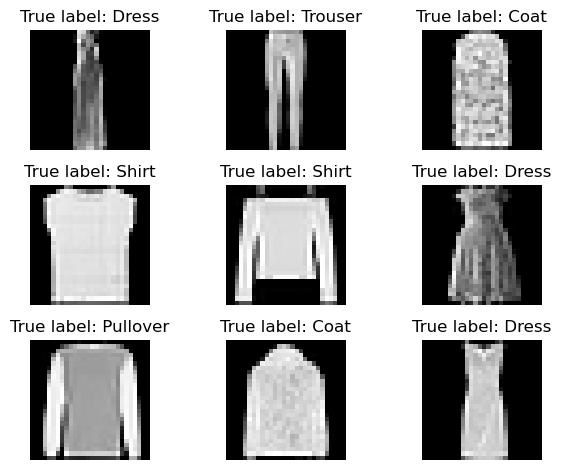

In [86]:
plt.figure()
for i in range (9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(0, len(train_images))
    plt.imshow(train_images[index],cmap='gray')
    plt.title(f'True label: {class_labels[train_labels[index]]}')
    plt.axis('off')

plt.tight_layout()    
plt.show()

In [87]:
train_images = train_images / 255.0
validation_images = validation_images / 255.0
X_test = X_test / 255.0

In [88]:
train_images = train_images[..., np.newaxis]
validation_images = validation_images[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [89]:
model_cnn_fashion = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax') 
]) 

In [90]:
model_cnn_fashion.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [91]:
early_stop= EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True)

In [94]:
history_fashion = model_cnn_fashion.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stop]
)
test_loss, test_acc = model_cnn_fashion.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9087 - loss: 0.2441 - val_accuracy: 0.9105 - val_loss: 0.2437
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9100 - loss: 0.2386 - val_accuracy: 0.9109 - val_loss: 0.2363
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9135 - loss: 0.2297 - val_accuracy: 0.9134 - val_loss: 0.2414
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9134 - loss: 0.2344 - val_accuracy: 0.9155 - val_loss: 0.2309
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9130 - loss: 0.2315 - val_accuracy: 0.9136 - val_loss: 0.2336
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9155 - loss: 0.2261 - val_accuracy: 0.9185 - val_loss: 0.2300
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9176 - loss: 0.2249 - val_accuracy: 0.9125 - val_loss: 0.2357
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9174 - loss: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


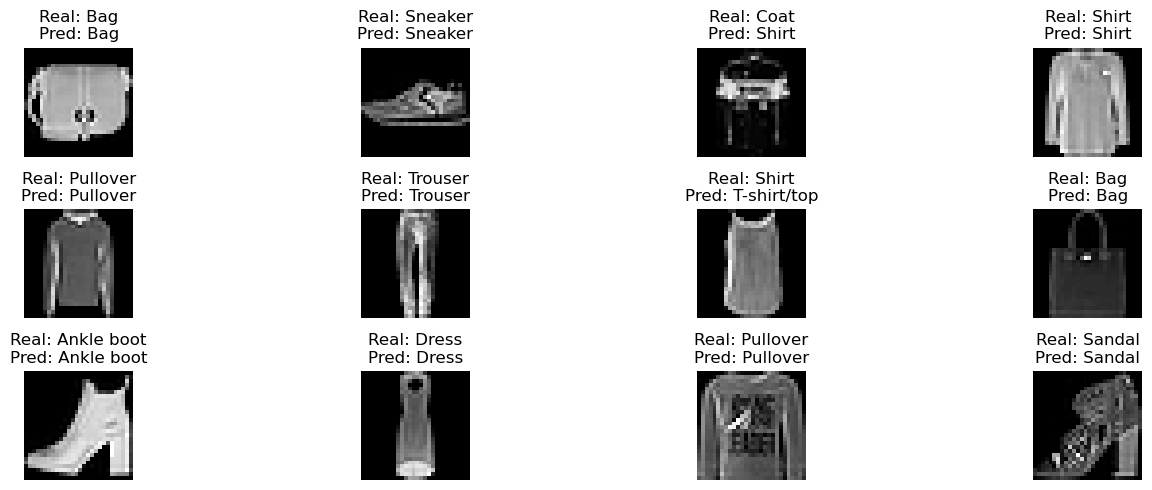

In [96]:
predictions = model_cnn_fashion.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 5))
for i in range(12):
    index = np.random.randint(0, len(X_test))
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    plt.title(f"Real: {class_labels[y_test[index]]}\nPred: {class_labels[predicted_labels[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [98]:

# #Tracer l'historique
# plt.figure(figsize=(12, 4))
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history_fashion.history['loss'], label='Training Loss')
# plt.plot(history_fashion.history['val_loss'], label='Validation Loss')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history_fashion.history['accuracy'], label='Training Accuracy')
# plt.plot(history_fashion.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()